### Prerequisites

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate, Softmax, Dot, Reshape, Dropout
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from google.colab import drive
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Import Data

In [ ]:
X,Y = preprocessing(df_lsb)
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
y_train_onehot, y_test_onehot, y_val_onehot, output_shape = one_hot(y_train,y_test,y_val)

NameError: name 'preprocessing' is not defined

In [ ]:
# import data
# 2 classes
df_bp = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c2_bp.csv')
df_lb = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c2_lb.csv')
df_lp = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c2_lp.csv')
df_ls = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c2_ls.csv')
df_sb = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c2_sb.csv')
df_sp = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c2_sp.csv')
# 3 classes
df_lbp = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c3_lbp.csv')
df_lsb = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c3_lsb.csv')
df_lsp = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c3_lsp.csv')
df_sbp = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c3_sbp.csv')
# 4 classes
df_lsbp = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c4_lsbp.csv')

df_c2 = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/df_c2.csv') #bar and pie


validation_accuracies = {}

<ipython-input-3-8a849ce0bb88>:3: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bp = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c2_bp.csv')
<ipython-input-3-8a849ce0bb88>:4: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lb = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c2_lb.csv')
<ipython-input-3-8a849ce0bb88>:5: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lp = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c2_lp.csv')
<ipython-input-3-8a849ce0bb88>:6: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ls = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/c2_ls.csv')
<ipython-input-3-8a849ce0bb88>:8: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=Fals

## Data preprocessing


In [ ]:
def preprocessing(df):
  y = df['Plot_Type']  # Labels
  df = df.rename(columns={'Plot_Type':'Label'})

  X_categorical = pd.DataFrame()
  X_numerical = pd.DataFrame()
  X_boolean = pd.DataFrame()
  Y = df["Label"].values
  df = df.drop(labels = ['Label'], axis=1)

  # splitting data to categorical and numerical for later purposes
  for column in df.columns:
      if df[column].dtype == 'object':
          X_categorical[column] = df[column]
      elif df[column].dtype == 'bool':
          X_boolean[column] = df[column].astype(int)
      else:
          X_numerical[column] = df[column]

  # 1) Set numerical features above the 99th percentile or below the 1st percentile to those respective cut-offs
  percentile_1 = X_numerical.quantile(0.01)
  percentile_99 = X_numerical.quantile(0.99)
  for column in X_numerical.columns:
      X_numerical[column] = np.where(X_numerical[column] > percentile_99[column], percentile_99[column], X_numerical[column])
      X_numerical[column] = np.where(X_numerical[column] < percentile_1[column], percentile_1[column], X_numerical[column])

  # 2) Remove the mean of numeric fields and scale to unit variance
  scaler = StandardScaler()
  numeric_data = X_numerical.select_dtypes(include=['float64', 'int64'])
  scaler.fit(numeric_data)
  scaled_numeric_data = scaler.transform(numeric_data)
  X_numerical[numeric_data.columns] = scaled_numeric_data

  #################### FLAGGING REPLACE WITH INF ########################
  # 3a) Impute missing categorical values using the mode of non missing values
  for column in X_categorical.columns:
      #if X_categorical[column].dtype == 'object':
      mode_val = X_categorical[column].mode()[0]
      X_categorical[column].fillna(mode_val, inplace=True)

  # 3b) Impute missing numerical values with mean of non-missing values
  for column in X_numerical.columns:
      #if pd.api.types.is_numeric_dtype(X_numerical[column].dtype):
      mean_val = X_numerical[column].mean()
      median_val = X_numerical[column].median()
      item = -9999999999
      #X_numerical[column].fillna(np.inf, inplace=True)
      X_numerical[column].fillna(mean_val, inplace=True)


  # 4) One-hot encoding to categorical features
  one_hot_encoder = OneHotEncoder()
  X_categorical_encoded = one_hot_encoder.fit_transform(X_categorical).toarray()
  encoded_feature_names = one_hot_encoder.get_feature_names_out(X_categorical.columns)
  X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=encoded_feature_names)
  X = pd.concat([X_numerical, X_categorical_encoded_df, X_boolean], axis=1)
  return X,Y

### Split Data

In [ ]:
X,Y = preprocessing(df_lsbp)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=100, stratify=Y)

NameError: name 'df_lsbp' is not defined

In [ ]:
print(X.columns.tolist())

['Num_Entries_X', 'Num_Entries_Y', 'Normalized Range (X)', 'Normalized Range (Y)', 'Num_Unique_X', 'Num_Unique_Y', 'Num_None_X', 'Percentage_None_X', 'Num_None_Y', 'Percentage_None_Y', 'Normalized Mean (X)', 'Normalized Median (X)', 'Sample Variance (X)', 'Sample Standard Deviation (X)', 'Coefficient of Variation (X)', 'Minimum Value (X)', 'Maximum Value (X)', 'Normalized Mean (Y)', 'Normalized Median (Y)', 'Sample Variance (Y)', 'Sample Standard Deviation (Y)', 'Coefficient of Variation (Y)', 'Minimum Value (Y)', 'Maximum Value (Y)', 'Mean C (X)', 'Median C (X)', 'Min C (X)', 'Max C (X)', 'Std C (X)', 'Unique C (X)', 'Mean C (Y)', 'Median C (Y)', 'Min C (Y)', 'Max C (Y)', 'Std C (Y)', 'Unique C (Y)', 'Num Identical Elements', 'Percent Shared Elements', 'Identical', 'Num Shared Unique Elements', 'Percent Shared Unique Elements', 'Correlation Value', 'Correlation P', 'Ks Statistic', 'Ks P', 'Q Entropy (X)', 'Q Entropy (Y)', 'C Entropy (X)', 'C Entropy (Y)', 'Perc Mode (X)', 'Perc Mode (

### Label One-Hot Encoding

In [ ]:
# One-hot encode the labels
label_encoder = LabelEncoder()

def one_hot(y_train,y_test,y_val):
  train_integer_encoded = label_encoder.fit_transform(y_train)
  test_integer_encoded = label_encoder.fit_transform(y_test)
  val_integer_encoded = label_encoder.fit_transform(y_val)
  y_train_onehot = to_categorical(train_integer_encoded)
  y_test_onehot = to_categorical(test_integer_encoded)
  y_val_onehot = to_categorical(val_integer_encoded)

  output_shape = y_test_onehot.shape[1]

  label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
  print(label_mapping)
  return y_train_onehot,y_test_onehot,y_val_onehot, output_shape

#y_train_onehot,y_test_onehot,_,output_shape = one_hot(y_train,y_test)

## Build and Train the Model

#### Callbacks


In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=60, min_delta=1e-3, verbose=1, restore_best_weights = True)

lr_schedule = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=15, min_delta=10e-3, min_lr=1e-6, verbose=1)

checkpoint = ModelCheckpoint(
    'best_model.keras',  # File path to save the model
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='max',  # We are looking for the maximum validation accuracy
    verbose=0  # Print messages when saving model
)

### C=2

#### BAR - PIE

In [ ]:
X,Y = preprocessing(df_bp)
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
y_train_onehot, y_test_onehot, y_val_onehot, output_shape = one_hot(y_train,y_test,y_val)

{0: 'bar', 1: 'pie'}


In [ ]:
input_shape = X_train.shape[1:]
init_neurons = X_train.shape[1]
custom_optimizer = Adam(learning_rate=0.00005)

# Define the model
model_c2_bp = tf.keras.models.Sequential([
    Dense(init_neurons, activation='relu', input_shape=input_shape),
    Dense(45, activation='relu'),
    Dense(45, activation='relu'),
    Dense(output_shape, activation='softmax')
])

model_c2_bp.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_c2_bp = model_c2_bp.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot), callbacks=[lr_schedule, checkpoint])
best_val_accuracy_c2_bp = max(history_c2_bp.history['val_accuracy'])
validation_accuracies['model_c2_bp'] = best_val_accuracy_c2_bp

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5896 - loss: 0.6671 - val_accuracy: 0.7184 - val_loss: 0.6015 - learning_rate: 5.0000e-05
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7317 - loss: 0.5766 - val_accuracy: 0.7578 - val_loss: 0.5499 - learning_rate: 5.0000e-05
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7673 - loss: 0.5310 - val_accuracy: 0.7724 - val_loss: 0.5210 - learning_rate: 5.0000e-05
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7808 - loss: 0.5089 - val_accuracy: 0.7772 - val_loss: 0.5051 - learning_rate: 5.0000e-05
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7915 - loss: 0.4836 - val_accuracy: 0.7816 - val_loss: 0.4956 - learning_rate: 5.0000e-05
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7783 - loss: 0.4842 - val_accuracy: 0.7821 - val_loss: 0.4883 - learning_rate: 5.0000e-05
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 

In [ ]:
history_c2_bp = model_c2_bp.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot), callbacks=[lr_schedule, checkpoint])
best_val_accuracy_c2_bp = max(history_c2_bp.history['val_accuracy'])
validation_accuracies['model_c2_bp'] = best_val_accuracy_c2_bp

Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5507 - loss: 0.7635 - val_accuracy: 0.7044 - val_loss: 0.6268 - learning_rate: 5.0000e-05
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7248 - loss: 0.6068 - val_accuracy: 0.7562 - val_loss: 0.5552 - learning_rate: 5.0000e-05
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7498 - loss: 0.5434 - val_accuracy: 0.7691 - val_loss: 0.5213 - learning_rate: 5.0000e-05
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7735 - loss: 0.4991 - val_accuracy: 0.7783 - val_loss: 0.5048 - learning_rate: 5.0000e-05
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7785 - loss: 0.4903 - val_accuracy: 0.7783 - val_loss: 0.4957 - learning_rate: 5.0000e-05
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7756 - loss: 0.4798 - val_accuracy: 0.7837 - val_loss: 0.4887 - learning_rate: 5.0000e-05
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 

#### LINE - BAR

In [ ]:
X,Y = preprocessing(df_lb)
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
y_train_onehot, y_test_onehot, y_val_onehot, output_shape = one_hot(y_train,y_test,y_val)

input_shape = X_train.shape[1:]
init_neurons = X_train.shape[1]
custom_optimizer = Adam(learning_rate=0.00005)

# Define the model
model_c2_lb = tf.keras.models.Sequential([
    Dense(init_neurons, activation='relu', input_shape=input_shape),
    Dense(45, activation='relu'),
    Dense(45, activation='relu'),
    Dense(output_shape, activation='softmax')
])

model_c2_lb.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_c2_lb = model_c2_lb.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot), callbacks=[lr_schedule, checkpoint])
best_val_accuracy_c2_lb = max(history_c2_lb.history['val_accuracy'])
validation_accuracies['model_c2_lb'] = best_val_accuracy_c2_lb

{0: 'bar', 1: 'line'}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5965 - loss: 0.6520 - val_accuracy: 0.7778 - val_loss: 0.5531 - learning_rate: 5.0000e-05
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7931 - loss: 0.5238 - val_accuracy: 0.8242 - val_loss: 0.4500 - learning_rate: 5.0000e-05
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8143 - loss: 0.4431 - val_accuracy: 0.8360 - val_loss: 0.3966 - learning_rate: 5.0000e-05
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8394 - loss: 0.3821 - val_accuracy: 0.8430 - val_loss: 0.3684 - learning_rate: 5.0000e-05
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8482 - loss: 0.3568 - val_accuracy: 0.8533 - val_loss: 0.3518 - learning_rate: 5.0000e-05
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8529 - loss: 0.3492 - val_accuracy: 0.8549 - val_loss: 0.3423 - learning_rate: 5.0000e-05
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8611 - lo

#### LINE - PIE

In [ ]:
X,Y = preprocessing(df_lp)
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 * 0.8 = 0.2
y_train_onehot, y_test_onehot, y_val_onehot, output_shape = one_hot(y_train,y_test,y_val)

input_shape = X_train.shape[1:]
init_neurons = X_train.shape[1]
custom_optimizer = Adam(learning_rate=0.00005)

# Define the model
model_c2_lp = tf.keras.models.Sequential([
    Dense(init_neurons, activation='relu', input_shape=input_shape),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(output_shape, activation='softmax')
])

model_c2_lp.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_c2_lp = model_c2_lp.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot), callbacks=[lr_schedule, checkpoint])
best_val_accuracy_c2_lp = max(history_c2_lp.history['val_accuracy'])
validation_accuracies['model_c2_lp'] = best_val_accuracy_c2_lp

{0: 'line', 1: 'pie'}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7285 - loss: 0.6256 - val_accuracy: 0.9137 - val_loss: 0.4680 - learning_rate: 5.0000e-05
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9264 - loss: 0.4089 - val_accuracy: 0.9353 - val_loss: 0.2739 - learning_rate: 5.0000e-05
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9472 - loss: 0.2352 - val_accuracy: 0.9466 - val_loss: 0.1883 - learning_rate: 5.0000e-05
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9503 - loss: 0.1749 - val_accuracy: 0.9525 - val_loss: 0.1559 - learning_rate: 5.0000e-05
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9603 - loss: 0.1325 - val_accuracy: 0.9552 - val_loss: 0.1397 - learning_rate: 5.0000e-05
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9573 - loss: 0.1332 - val_accuracy: 0.9563 - val_loss: 0.1304 - learning_rate: 5.0000e-05
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 

#### LINE - SCATTER

In [ ]:
X,Y = preprocessing(df_ls)
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
y_train_onehot, y_test_onehot, y_val_onehot, output_shape = one_hot(y_train,y_test,y_val)

input_shape = X_train.shape[1:]
init_neurons = X_train.shape[1]
custom_optimizer = Adam(learning_rate=0.00005)

# Define the model
model_c2_ls = tf.keras.models.Sequential([
    Dense(init_neurons, activation='relu', input_shape=input_shape),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(output_shape, activation='softmax')
])

model_c2_ls.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_c2_ls = model_c2_ls.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot), callbacks=[lr_schedule, checkpoint])
best_val_accuracy_c2_ls = max(history_c2_ls.history['val_accuracy'])
validation_accuracies['model_c2_ls'] = best_val_accuracy_c2_ls

{0: 'line', 1: 'scatter'}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4925 - loss: 0.7394 - val_accuracy: 0.5469 - val_loss: 0.6927 - learning_rate: 5.0000e-05
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5557 - loss: 0.6850 - val_accuracy: 0.6084 - val_loss: 0.6700 - learning_rate: 5.0000e-05
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6119 - loss: 0.6662 - val_accuracy: 0.6273 - val_loss: 0.6579 - learning_rate: 5.0000e-05
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6291 - loss: 0.6552 - val_accuracy: 0.6321 - val_loss: 0.6504 - learning_rate: 5.0000e-05
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6362 - loss: 0.6456 - val_accuracy: 0.6338 - val_loss: 0.6452 - learning_rate: 5.0000e-05
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6233 - loss: 0.6466 - val_accuracy: 0.6327 - val_loss: 0.6417 - learning_rate: 5.0000e-05
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6337 - lo

#### SCATTER - BAR


In [ ]:
X,Y = preprocessing(df_sb)
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
y_train_onehot, y_test_onehot, y_val_onehot, output_shape = one_hot(y_train,y_test,y_val)

input_shape = X_train.shape[1:]
init_neurons = X_train.shape[1]
custom_optimizer = Adam(learning_rate=0.00005)

# Define the model
model_c2_sb = tf.keras.models.Sequential([
    Dense(init_neurons, activation='relu', input_shape=input_shape),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(output_shape, activation='softmax')
])

model_c2_sb.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_c2_sb = model_c2_sb.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot), callbacks=[lr_schedule, checkpoint])
best_val_accuracy_c2_sb = max(history_c2_sb.history['val_accuracy'])
validation_accuracies['model_c2_sb'] = best_val_accuracy_c2_sb

{0: 'bar', 1: 'scatter'}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5122 - loss: 0.7116 - val_accuracy: 0.6990 - val_loss: 0.6157 - learning_rate: 5.0000e-05
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7181 - loss: 0.6003 - val_accuracy: 0.7654 - val_loss: 0.5314 - learning_rate: 5.0000e-05
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7755 - loss: 0.5170 - val_accuracy: 0.7869 - val_loss: 0.4804 - learning_rate: 5.0000e-05
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7925 - loss: 0.4771 - val_accuracy: 0.8010 - val_loss: 0.4529 - learning_rate: 5.0000e-05
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7978 - loss: 0.4569 - val_accuracy: 0.8112 - val_loss: 0.4361 - learning_rate: 5.0000e-05
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8043 - loss: 0.4473 - val_accuracy: 0.8139 - val_loss: 0.4256 - learning_rate: 5.0000e-05
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8118 - lo

#### SCATTER - PIE

In [ ]:
X,Y = preprocessing(df_sp)
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
y_train_onehot, y_test_onehot, y_val_onehot, output_shape = one_hot(y_train,y_test,y_val)

input_shape = X_train.shape[1:]
init_neurons = X_train.shape[1]
custom_optimizer = Adam(learning_rate=0.00005)

# Define the model
model_c2_sp = tf.keras.models.Sequential([
    Dense(init_neurons, activation='relu', input_shape=input_shape),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(output_shape, activation='softmax')
])

model_c2_sp.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_c2_sp = model_c2_sp.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot), callbacks=[lr_schedule, checkpoint])
best_val_accuracy_c2_sp = max(history_c2_sp.history['val_accuracy'])
validation_accuracies['model_c2_sp'] = best_val_accuracy_c2_sp

{0: 'pie', 1: 'scatter'}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5880 - loss: 0.6471 - val_accuracy: 0.8781 - val_loss: 0.4577 - learning_rate: 5.0000e-05
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9056 - loss: 0.4040 - val_accuracy: 0.9142 - val_loss: 0.2970 - learning_rate: 5.0000e-05
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9302 - loss: 0.2618 - val_accuracy: 0.9261 - val_loss: 0.2319 - learning_rate: 5.0000e-05
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9390 - loss: 0.2055 - val_accuracy: 0.9293 - val_loss: 0.2060 - learning_rate: 5.0000e-05
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9325 - loss: 0.1888 - val_accuracy: 0.9293 - val_loss: 0.1935 - learning_rate: 5.0000e-05
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9351 - loss: 0.1726 - val_accuracy: 0.9337 - val_loss: 0.1857 - learning_rate: 5.0000e-05
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9397 - lo

In [ ]:
print(f"Best validation accuracy: {best_val_accuracy_c2_sp * 100:.2f}%")

Best validation accuracy: 95.20%


### C=3

#### LINE - BAR - PIE

In [ ]:
X,Y = preprocessing(df_lbp)
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
y_train_onehot, y_test_onehot, y_val_onehot, output_shape = one_hot(y_train,y_test,y_val)

input_shape = X_train.shape[1:]
init_neurons = X_train.shape[1]
custom_optimizer = Adam(learning_rate=0.0005)

# Define the model
model_c3_lbp = tf.keras.models.Sequential([
    Dense(init_neurons, activation='relu', input_shape=input_shape),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(output_shape, activation='softmax')
])

model_c3_lbp.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_c3_lbp = model_c3_lbp.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot), callbacks=[lr_schedule, checkpoint])
best_val_accuracy_c3_lbp = max(history_c3_lbp.history['val_accuracy'])
validation_accuracies['model_c3_lbp'] = best_val_accuracy_c3_lbp

{0: 'bar', 1: 'line', 2: 'pie'}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6246 - loss: 0.8001 - val_accuracy: 0.7533 - val_loss: 0.5641 - learning_rate: 5.0000e-04
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7546 - loss: 0.5487 - val_accuracy: 0.7652 - val_loss: 0.5434 - learning_rate: 5.0000e-04
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7680 - loss: 0.5251 - val_accuracy: 0.7620 - val_loss: 0.5397 - learning_rate: 5.0000e-04
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7798 - loss: 0.5099 - val_accuracy: 0.7695 - val_loss: 0.5316 - learning_rate: 5.0000e-04
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7909 - loss: 0.4967 - val_accuracy: 0.7666 - val_loss: 0.5277 - learning_rate: 5.0000e-04
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7914 - loss: 0.4888 - val_accuracy: 0.7767 - val_loss: 0.5222 - learning_rate: 5.0000e-04
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7900 - lo

#### LINE - SCATTER - BAR

In [ ]:
X,Y = preprocessing(df_lsb)
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
y_train_onehot, y_test_onehot, y_val_onehot, output_shape = one_hot(y_train,y_test,y_val)

{0: 'bar', 1: 'line', 2: 'scatter'}


In [ ]:
# best model so far
input_shape = X_train.shape[1:]
init_neurons = X_train.shape[1]
custom_optimizer = Adam(learning_rate=0.00005)

# Define the model
model_c3_lsb = tf.keras.models.Sequential([
    Dense(init_neurons, activation='relu', input_shape=input_shape),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(output_shape, activation='softmax')
])

model_c3_lsb.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), callbacks=[reduce_lr])
history_c3_lsb = model_c3_lsb.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot), callbacks=[lr_schedule, early_stopping, checkpoint])
best_val_accuracy_c3_lsb = max(history_c3_lsb.history['val_accuracy'])
validation_accuracies['model_c3_lsb'] = best_val_accuracy_c3_lsb

Epoch 1/50
261/261 [==============================] - 3s 6ms/step - loss: 1.0696 - accuracy: 0.4259 - val_loss: 1.0229 - val_accuracy: 0.5138 - lr: 5.0000e-05
Epoch 2/50
261/261 [==============================] - 1s 3ms/step - loss: 0.9677 - accuracy: 0.5590 - val_loss: 0.9196 - val_accuracy: 0.5778 - lr: 5.0000e-05
Epoch 3/50
261/261 [==============================] - 1s 3ms/step - loss: 0.8777 - accuracy: 0.5901 - val_loss: 0.8566 - val_accuracy: 0.5980 - lr: 5.0000e-05
Epoch 4/50
261/261 [==============================] - 1s 3ms/step - loss: 0.8326 - accuracy: 0.6049 - val_loss: 0.8293 - val_accuracy: 0.6052 - lr: 5.0000e-05
Epoch 5/50
261/261 [==============================] - 1s 3ms/step - loss: 0.8108 - accuracy: 0.6133 - val_loss: 0.8150 - val_accuracy: 0.6142 - lr: 5.0000e-05
Epoch 6/50
261/261 [==============================] - 1s 3ms/step - loss: 0.7977 - accuracy: 0.6161 - val_loss: 0.8065 - val_accuracy: 0.6206 - lr: 5.0000e-05
Epoch 7/50
261/261 [==========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


261/261 [==============================] - 1s 3ms/step - loss: 0.7390 - accuracy: 0.6510 - val_loss: 0.7741 - val_accuracy: 0.6408 - lr: 5.0000e-05
Epoch 21/50
261/261 [==============================] - 1s 3ms/step - loss: 0.7370 - accuracy: 0.6501 - val_loss: 0.7749 - val_accuracy: 0.6401 - lr: 5.0000e-05
Epoch 22/50
261/261 [==============================] - 1s 3ms/step - loss: 0.7347 - accuracy: 0.6502 - val_loss: 0.7730 - val_accuracy: 0.6411 - lr: 5.0000e-05
Epoch 23/50
261/261 [==============================] - 1s 3ms/step - loss: 0.7327 - accuracy: 0.6544 - val_loss: 0.7726 - val_accuracy: 0.6411 - lr: 5.0000e-05
Epoch 24/50
261/261 [==============================] - 1s 3ms/step - loss: 0.7310 - accuracy: 0.6548 - val_loss: 0.7724 - val_accuracy: 0.6437 - lr: 5.0000e-05
Epoch 25/50
261/261 [==============================] - 1s 3ms/step - loss: 0.7289 - accuracy: 0.6568 - val_loss: 0.7721 - val_accuracy: 0.6411 - lr: 5.0000e-05
Epoch 26/50
261/261 [==============================]

#### LINE - SCATTER - PIE

In [ ]:
X,Y = preprocessing(df_lsp)
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
y_train_onehot, y_test_onehot, y_val_onehot, output_shape = one_hot(y_train,y_test,y_val)

input_shape = X_train.shape[1:]
init_neurons = X_train.shape[1]
custom_optimizer = Adam(learning_rate=0.0005)

# Define the model
model_c3_lsp = tf.keras.models.Sequential([
    Dense(init_neurons, activation='relu', input_shape=input_shape),
    Dense(180, activation='relu'),
    Dense(output_shape, activation='softmax')
])

model_c3_lsp.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_c3_lsp = model_c3_lsp.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot), callbacks=[lr_schedule, checkpoint])
best_val_accuracy_c3_lsp = max(history_c3_lsp.history['val_accuracy'])
validation_accuracies['model_c3_lsp'] = best_val_accuracy_c3_lsp

{0: 'line', 1: 'pie', 2: 'scatter'}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6213 - loss: 0.7567 - val_accuracy: 0.7220 - val_loss: 0.5552 - learning_rate: 5.0000e-04
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7267 - loss: 0.5459 - val_accuracy: 0.7224 - val_loss: 0.5477 - learning_rate: 5.0000e-04
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7333 - loss: 0.5274 - val_accuracy: 0.7246 - val_loss: 0.5404 - learning_rate: 5.0000e-04
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7346 - loss: 0.5245 - val_accuracy: 0.7213 - val_loss: 0.5423 - learning_rate: 5.0000e-04
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7351 - loss: 0.5124 - val_accuracy: 0.7260 - val_loss: 0.5397 - learning_rate: 5.0000e-04
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7483 - loss: 0.5044 - val_accuracy: 0.7224 - val_loss: 0.5461 - learning_rate: 5.0000e-04
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7506 - lo

#### SCATTER - BAR - PIE

In [ ]:
X,Y = preprocessing(df_sbp)
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
y_train_onehot, y_test_onehot, y_val_onehot, output_shape = one_hot(y_train,y_test,y_val)

input_shape = X_train.shape[1:]
init_neurons = X_train.shape[1]
custom_optimizer = Adam(learning_rate=0.0005)

# Define the model
model_c3_sbp = tf.keras.models.Sequential([
    Dense(init_neurons, activation='relu', input_shape=input_shape),
    Dense(180, activation='relu'),
    Dense(output_shape, activation='softmax')
])

model_c3_sbp.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_c3_sbp = model_c3_sbp.fit(X_train, y_train_onehot, epochs=50, validation_data=(X_val, y_val_onehot), callbacks=[lr_schedule, checkpoint])
best_val_accuracy_c3_sbp = max(history_c3_sbp.history['val_accuracy'])
validation_accuracies['model_c3_sbp'] = best_val_accuracy_c3_sbp

{0: 'bar', 1: 'pie', 2: 'scatter'}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6344 - loss: 0.7874 - val_accuracy: 0.7278 - val_loss: 0.6382 - learning_rate: 5.0000e-04
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7355 - loss: 0.6018 - val_accuracy: 0.7361 - val_loss: 0.6226 - learning_rate: 5.0000e-04
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7434 - loss: 0.5808 - val_accuracy: 0.7364 - val_loss: 0.6116 - learning_rate: 5.0000e-04
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7493 - loss: 0.5713 - val_accuracy: 0.7379 - val_loss: 0.6129 - learning_rate: 5.0000e-04
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7538 - loss: 0.5556 - val_accuracy: 0.7487 - val_loss: 0.6049 - learning_rate: 5.0000e-04
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7603 - loss: 0.5359 - val_accuracy: 0.7573 - val_loss: 0.5981 - learning_rate: 5.0000e-04
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7671 - lo

### C=4

#### LINE - SCATTER - BAR - PIE

In [ ]:
X,Y = preprocessing(df_lsbp)
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
y_train_onehot, y_test_onehot, y_val_onehot, output_shape = one_hot(y_train,y_test,y_val)

input_shape = X_train.shape[1:]
init_neurons = X_train.shape[1]
custom_optimizer = Adam(learning_rate=0.0005)

# Define the model
model_c4_lsbp = tf.keras.models.Sequential([
    Dense(init_neurons, activation='relu', input_shape=input_shape),
    Dense(180, activation='relu'),
    Dense(output_shape, activation='softmax')
])

model_c4_lsbp.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_c4_lsbp = model_c4_lsbp.fit(X_train, y_train_onehot, epochs=100, validation_data=(X_val, y_val_onehot), callbacks=[lr_schedule, checkpoint])
best_val_accuracy_c4_lsbp = max(history_c4_lsbp.history['val_accuracy'])
validation_accuracies['model_c4_lsbp'] = best_val_accuracy_c4_lsbp

{0: 'bar', 1: 'line', 2: 'pie', 3: 'scatter'}
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5098 - loss: 1.0754 - val_accuracy: 0.5928 - val_loss: 0.8640 - learning_rate: 5.0000e-04
Epoch 2/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6079 - loss: 0.8415 - val_accuracy: 0.6173 - val_loss: 0.8516 - learning_rate: 5.0000e-04
Epoch 3/100
 33/348 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6214 - loss: 0.8168    

### Results

In [ ]:
model_c2_bp.save('c2_bp.h5')
model_c2_lb.save('c2_lb.h5')
model_c2_lp.save('c2_lp.h5')
model_c2_ls.save('c2_ls.h5')
model_c2_sb.save('c2_sb.h5')
model_c2_sp.save('c2_sp.h5')

model_c3_lbp.save('c3_lbp.h5')
model_c3_lsb.save('c3_lsb.h5')
model_c3_lsp.save('c3_lsp.h5')
model_c3_sbp.save('c3_sbp.h5')

model_c4_lsbp.save('c4_lsbp.h5')

In [ ]:
model_c2_lb.save('c2_lb.h5')

In [ ]:
accuracy_df = pd.DataFrame(list(validation_accuracies.items()), columns=['Model', 'Validation Accuracy'])

# Display the DataFrame
print(accuracy_df)

           Model  Validation Accuracy
0    model_c2_bp             0.809601
1   model_c3_sbl             0.640058
2   model_c3_sbp             0.759079
3  model_c4_lsbp             0.630259


### Train

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

87/87 [==============================] - 0s 4ms/step - loss: 0.7512 - accuracy: 0.6516
Test Loss: 0.7512138485908508
Test Accuracy: 0.6515641808509827


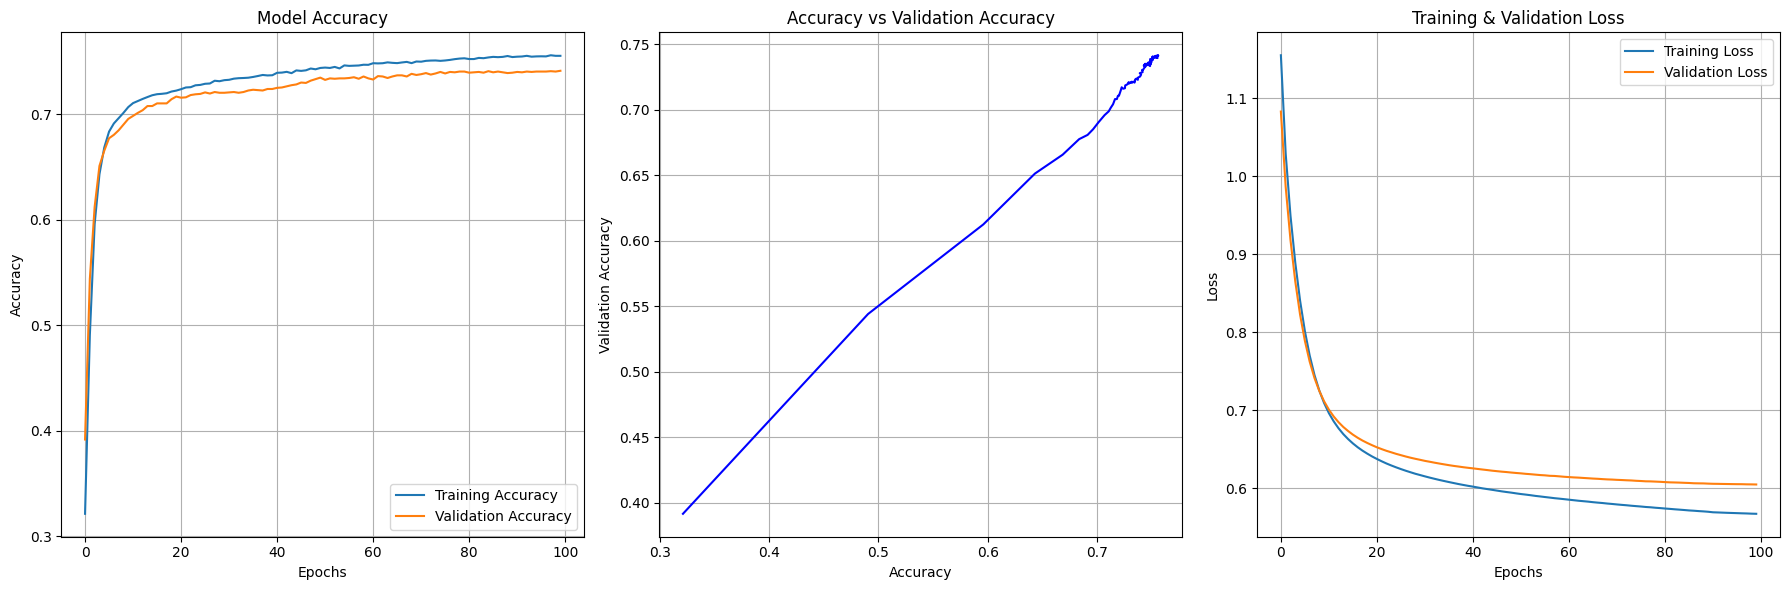

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot accuracy vs validation accuracy
axes[1].plot(history.history['accuracy'], history.history['val_accuracy'], color='b')
axes[1].set_title('Accuracy vs Validation Accuracy')
axes[1].set_xlabel('Accuracy')
axes[1].set_ylabel('Validation Accuracy')
axes[1].grid(True)

# Plot loss
axes[2].plot(history.history['loss'], label='Training Loss')
axes[2].plot(history.history['val_loss'], label='Validation Loss')
axes[2].set_title('Training & Validation Loss')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True)


plt.tight_layout()
plt.show()

In [ ]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 94)                8930      
                                                                 
 dense_83 (Dense)            (None, 60)                5700      
                                                                 
 dense_84 (Dense)            (None, 120)               7320      
                                                                 
 dense_85 (Dense)            (None, 3)                 363       
                                                                 
Total params: 22313 (87.16 KB)
Trainable params: 22313 (87.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Evaluate

In [ ]:
loaded_model.evaluate(X_test, y_test_onehot)

58/58 [==============================] - 0s 2ms/step - loss: 0.4362 - accuracy: 0.7977


[0.4361858069896698, 0.7977346181869507]

In [ ]:
# Predictions for the first 5 entries in X_test
predictions = model.predict(X_test)

# Get the first 5 entries of X_test
first_5_features = X_test.iloc[:5]

#print("Features of the first 5 entries:")
#print(first_5_features)

print("Predictions for the first 5 entries:")
print(predictions[:5])

87/87 [==============================] - 0s 3ms/step
Predictions for the first 5 entries:
[[0.13459568 0.17437282 0.6910316 ]
 [0.23643495 0.3224262  0.4411387 ]
 [0.36317217 0.16284217 0.47398567]
 [0.85395026 0.04604641 0.1000033 ]
 [0.06831136 0.7595224  0.17216623]]


In [ ]:
# Convert predictions to labels
predicted_labels = [np.argmax(prediction) for prediction in predictions[:5]]

# Define your label mapping
label_mapping = {0: 'bar', 1: 'line', 2: 'scatter'}

# Convert labels to their corresponding strings
predicted_labels = [label_mapping[label] for label in predicted_labels]

print("Predicted labels for the first 5 entries:")
print(predicted_labels)

Predicted labels for the first 5 entries:
['scatter', 'scatter', 'scatter', 'bar', 'line']


In [ ]:
predicted_labels = np.argmax(predictions, axis=1)

# Count the occurrences of each class
counts = {
    'line': np.count_nonzero(predicted_labels == 0),
    'bar': np.count_nonzero(predicted_labels == 1),
    'scatter': np.count_nonzero(predicted_labels == 2)
}

# Print the counts
print("Number of line:", counts['line'])
print("Number of bar:", counts['bar'])
print("Number of scatter:", counts['scatter'])

Number of line: 893
Number of bar: 1032
Number of scatter: 856


### Learning Rate - Reduction

In [ ]:
# Define the learning rate schedule
lr_schedule = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, min_delta=1e-3, min_lr=1e-6, verbose=1)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=100, min_delta=1e-3, verbose=1)

# Define the custom optimizer
custom_optimizer = Adam(learning_rate=1e-5)

In [ ]:
# Define the model
model = tf.keras.models.Sequential([
    Dense(64, activation='relu', input_shape=input_shape),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the model
history = model.fit(X_train, y_train_onehot,
                    #batch_size=16,
                    epochs=300,
                    validation_data=(X_test, y_test_onehot),
                    callbacks=[lr_schedule, early_stopping],
                    verbose=1)

Epoch 1/300
348/348 [==============================] - 5s 9ms/step - loss: 1.2727 - accuracy: 0.3084 - val_loss: 1.2371 - val_accuracy: 0.3254 - lr: 1.0000e-05
Epoch 2/300
348/348 [==============================] - 1s 2ms/step - loss: 1.2157 - accuracy: 0.3360 - val_loss: 1.1873 - val_accuracy: 0.3567 - lr: 1.0000e-05
Epoch 3/300
348/348 [==============================] - 1s 2ms/step - loss: 1.1668 - accuracy: 0.3637 - val_loss: 1.1444 - val_accuracy: 0.3740 - lr: 1.0000e-05
Epoch 4/300
348/348 [==============================] - 1s 3ms/step - loss: 1.1245 - accuracy: 0.3892 - val_loss: 1.1071 - val_accuracy: 0.3948 - lr: 1.0000e-05
Epoch 5/300
348/348 [==============================] - 2s 7ms/step - loss: 1.0878 - accuracy: 0.4160 - val_loss: 1.0746 - val_accuracy: 0.4211 - lr: 1.0000e-05
Epoch 6/300
348/348 [==============================] - 1s 3ms/step - loss: 1.0556 - accuracy: 0.4413 - val_loss: 1.0460 - val_accuracy: 0.4506 - lr: 1.0000e-05
Epoch 7/300
348/348 [===================

KeyboardInterrupt: 

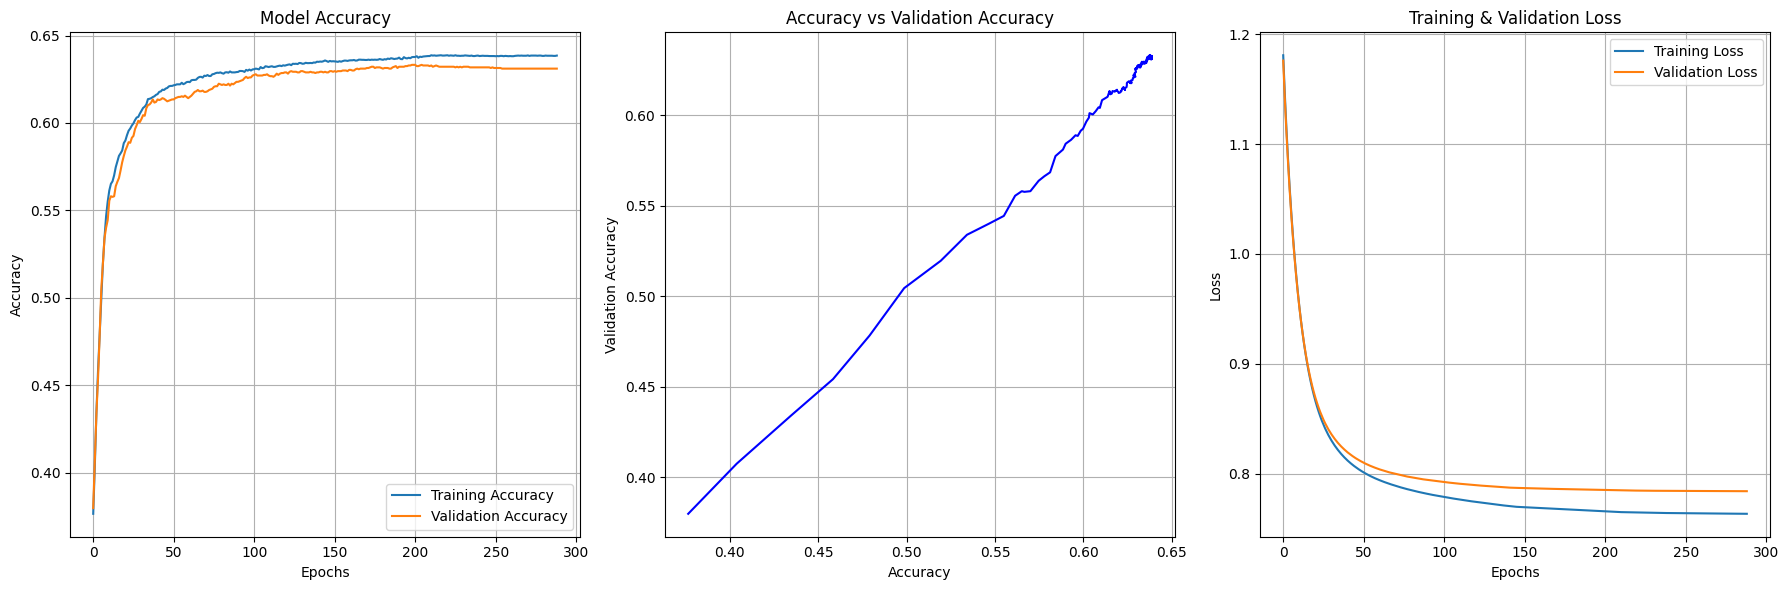

In [ ]:
import matplotlib.pyplot as plt

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Plot accuracy vs validation accuracy
axes[1].plot(history.history['accuracy'], history.history['val_accuracy'], color='b')
axes[1].set_title('Accuracy vs Validation Accuracy')
axes[1].set_xlabel('Accuracy')
axes[1].set_ylabel('Validation Accuracy')
axes[1].grid(True)

# Plot loss
axes[2].plot(history.history['loss'], label='Training Loss')
axes[2].plot(history.history['val_loss'], label='Validation Loss')
axes[2].set_title('Training & Validation Loss')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True)


plt.tight_layout()
plt.show()

In [ ]:
input_shape = X_train.shape[1:]
custom_optimizer = Adam(learning_rate=0.00001)

trial 1

In [ ]:
# Define the model
model = tf.keras.models.Sequential([
    Dense(58, activation='relu', input_shape=input_shape),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_onehot, epochs=10, validation_data=(X_test, y_test_onehot))

Epoch 1/10
348/348 [==============================] - 1s 3ms/step - loss: 0.8600 - accuracy: 0.5847 - val_loss: 0.7983 - val_accuracy: 0.6214
Epoch 2/10
348/348 [==============================] - 1s 2ms/step - loss: 0.7864 - accuracy: 0.6220 - val_loss: 0.7945 - val_accuracy: 0.6260
Epoch 3/10
348/348 [==============================] - 1s 2ms/step - loss: 0.7743 - accuracy: 0.6294 - val_loss: 0.7932 - val_accuracy: 0.6134
Epoch 4/10
348/348 [==============================] - 1s 2ms/step - loss: 0.7677 - accuracy: 0.6328 - val_loss: 0.7881 - val_accuracy: 0.6188
Epoch 5/10
348/348 [==============================] - 1s 2ms/step - loss: 0.7615 - accuracy: 0.6387 - val_loss: 0.7843 - val_accuracy: 0.6296
Epoch 6/10
348/348 [==============================] - 1s 2ms/step - loss: 0.7575 - accuracy: 0.6402 - val_loss: 0.7878 - val_accuracy: 0.6232
Epoch 7/10
348/348 [==============================] - 1s 2ms/step - loss: 0.7516 - accuracy: 0.6415 - val_loss: 0.7880 - val_accuracy: 0.6339
Epoch 

trial 2

In [ ]:
# Define the models and their configurations
init_neurons = X_train.shape[1]
model_configs = [
    (68, 30),
    (68, 90),
    (68, 120),
    (68, 150),
    (68, 180)
]

# Initialize lists to store models and histories
models1 = []
histories1 = []

# Loop over model configurations
for i, config in enumerate(model_configs, start=1):
    num_layers = len(config) - 1
    neurons = config[1]

    # Print the number of layers and neurons
    print(f"Trial {i}: Number of layers = {num_layers}, Number of neurons = {neurons}")
    model = tf.keras.models.Sequential([
        Dense(init_neurons, activation='relu', input_shape=input_shape),
        Dense(config[1], activation='relu'),
        Dense(3, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model and store the history
    history = model.fit(X_train, y_train_onehot, epochs=150, validation_data=(X_test, y_test_onehot))

    # Append the model and its history to the lists
    models1.append(model)
    histories1.append(history)

    # Print the history for reference
    print(f"History for model {i}:", history)


Trial 1: Number of layers = 1, Number of neurons = 30
Epoch 1/150
348/348 [==============================] - 2s 3ms/step - loss: 0.8204 - accuracy: 0.6083 - val_loss: 0.7755 - val_accuracy: 0.6293
Epoch 2/150
348/348 [==============================] - 1s 2ms/step - loss: 0.7625 - accuracy: 0.6376 - val_loss: 0.7686 - val_accuracy: 0.6368
Epoch 3/150
348/348 [==============================] - 1s 2ms/step - loss: 0.7488 - accuracy: 0.6462 - val_loss: 0.7584 - val_accuracy: 0.6429
Epoch 4/150
348/348 [==============================] - 1s 2ms/step - loss: 0.7366 - accuracy: 0.6521 - val_loss: 0.7590 - val_accuracy: 0.6419
Epoch 5/150
348/348 [==============================] - 1s 3ms/step - loss: 0.7282 - accuracy: 0.6573 - val_loss: 0.7582 - val_accuracy: 0.6476
Epoch 6/150
348/348 [==============================] - 1s 3ms/step - loss: 0.7202 - accuracy: 0.6593 - val_loss: 0.7558 - val_accuracy: 0.6480
Epoch 7/150
348/348 [==============================] - 1s 2ms/step - loss: 0.7160 - accu

In [ ]:
# Define the models and their configurations
model_configs = [
    (init_neurons, [30, 40, 50]),
    (init_neurons, [90, 100, 110]),
    (init_neurons, [120, 130, 140]),
    (init_neurons, [150, 160, 170]),
    (init_neurons, [180, 190, 200]),
    (init_neurons, [60, 70, 80, 90]),
    (init_neurons, [100, 110, 120, 130]),
    (init_neurons, [140, 150, 160, 170]),
    (init_neurons, [180, 190, 200, 210]),
    (init_neurons, [50, 100, 150, 200])
]

# Initialize lists to store models and histories
models2 = []
histories2 = []

# Loop over model configurations
for i, config in enumerate(model_configs, start=2):
    # Extract the number of layers and neurons
    num_layers = len(config[1])
    neurons = config[1]

    # Print the number of layers and neurons
    print(f"Trial {i}: Number of layers = {num_layers}, Number of neurons per layer = {neurons}")

    # Define the model
    model_layers = [Dense(config[0], activation='relu', input_shape=input_shape)]
    for neurons in config[1]:
        model_layers.append(Dense(neurons, activation='relu'))
    model_layers.append(Dense(3, activation='softmax'))

    model = tf.keras.models.Sequential(model_layers)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model and store the history
    history = model.fit(X_train, y_train_onehot, epochs=150, validation_data=(X_test, y_test_onehot))

    # Append the model and its history to the lists
    models2.append(model)
    histories2.append(history)

    # Print the history for reference
    print(f"History for model {i}:", history)


Trial 2: Number of layers = 3, Number of neurons per layer = [30, 40, 50]
Epoch 1/150
348/348 [==============================] - 4s 6ms/step - loss: 0.8238 - accuracy: 0.6072 - val_loss: 0.7783 - val_accuracy: 0.6260
Epoch 2/150
348/348 [==============================] - 1s 3ms/step - loss: 0.7651 - accuracy: 0.6393 - val_loss: 0.7709 - val_accuracy: 0.6221
Epoch 3/150
348/348 [==============================] - 1s 3ms/step - loss: 0.7468 - accuracy: 0.6452 - val_loss: 0.7604 - val_accuracy: 0.6361
Epoch 4/150
348/348 [==============================] - 1s 3ms/step - loss: 0.7402 - accuracy: 0.6495 - val_loss: 0.7495 - val_accuracy: 0.6401
Epoch 5/150
348/348 [==============================] - 1s 3ms/step - loss: 0.7282 - accuracy: 0.6561 - val_loss: 0.7606 - val_accuracy: 0.6393
Epoch 6/150
348/348 [==============================] - 1s 3ms/step - loss: 0.7206 - accuracy: 0.6591 - val_loss: 0.7504 - val_accuracy: 0.6519
Epoch 7/150
348/348 [==============================] - 1s 3ms/step -

In [ ]:
# Define the models and their configurations
model_configs = []
for num_layers in range(2, 6):
    for neurons in range(30, 181, 30):
        model_configs.append((num_layers, neurons))

# Initialize lists to store models and histories
models3 = []
histories3 = []

# Loop over model configurations
for i, config in enumerate(model_configs, start=2):
    # Extract the number of layers and neurons
    num_layers, neurons = config

    # Print the number of layers and neurons
    print(f"Trial {i}: Number of layers = {num_layers}, Number of neurons per layer = {neurons}")

    # Define the model
    model_layers = [Dense(68, activation='relu', input_shape=input_shape)]
    for _ in range(num_layers - 1):
        model_layers.append(Dense(neurons, activation='relu'))
    model_layers.append(Dense(3, activation='softmax'))

    model = tf.keras.models.Sequential(model_layers)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model and store the history
    history = model.fit(X_train, y_train_onehot, epochs=150, validation_data=(X_test, y_test_onehot))

    # Append the model and its history to the lists
    models3.append(model)
    histories3.append(history)

    # Print the history for reference
    print(f"History for model {i}:", history)


Streaming output truncated to the last 5000 lines.
348/348 [==============================] - 1s 4ms/step - loss: 0.5804 - accuracy: 0.7306 - val_loss: 0.9109 - val_accuracy: 0.6253
Epoch 36/150
348/348 [==============================] - 1s 4ms/step - loss: 0.5759 - accuracy: 0.7334 - val_loss: 0.9109 - val_accuracy: 0.6206
Epoch 37/150
348/348 [==============================] - 1s 4ms/step - loss: 0.5757 - accuracy: 0.7312 - val_loss: 0.9278 - val_accuracy: 0.6081
Epoch 38/150
348/348 [==============================] - 1s 4ms/step - loss: 0.5713 - accuracy: 0.7375 - val_loss: 0.9206 - val_accuracy: 0.6131
Epoch 39/150
348/348 [==============================] - 1s 4ms/step - loss: 0.5692 - accuracy: 0.7380 - val_loss: 0.9333 - val_accuracy: 0.6167
Epoch 40/150
348/348 [==============================] - 1s 4ms/step - loss: 0.5637 - accuracy: 0.7375 - val_loss: 0.9264 - val_accuracy: 0.6081
Epoch 41/150
348/348 [==============================] - 2s 4ms/step - loss: 0.5572 - accuracy: 0.7

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=100)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=100)

In [ ]:
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate and print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.6467098166127292
Confusion Matrix:
[[584  59 204  80]
 [ 50 524   6 347]
 [104   5 803  15]
 [ 88 337  15 487]]


Importances

In [ ]:
feature_names = df.columns.tolist()
importances = rf_classifier.feature_importances_

feature_importance_list = list(zip(feature_names, importances))
feature_importance_list.sort(key=lambda x: x[1], reverse=True)

print("Feature ranking:")
for i, (feature, importance) in enumerate(feature_importance_list):
    print(f"{i+1}. Feature '{feature}': Importance {importance:.4f}")

Feature ranking:
1. Feature 'Percent Shared Unique Elements': Importance 0.0437
2. Feature 'Median C (X)': Importance 0.0363
3. Feature 'X_Type': Importance 0.0355
4. Feature 'Num_Entries_Y': Importance 0.0336
5. Feature 'Sample Standard Deviation (X)': Importance 0.0330
6. Feature 'Identical Unique': Importance 0.0321
7. Feature 'Y_Type': Importance 0.0318
8. Feature 'Normalized Mean (Y)': Importance 0.0317
9. Feature 'Coefficient of Variation (X)': Importance 0.0314
10. Feature 'Q Entropy (X)': Importance 0.0300
11. Feature 'Ks Significant 005': Importance 0.0299
12. Feature 'Normalized Range (Y)': Importance 0.0299
13. Feature 'Normalized Median (Y)': Importance 0.0298
14. Feature 'Mean C (X)': Importance 0.0265
15. Feature 'Normalized Range (X)': Importance 0.0256
16. Feature 'Perc Mode (Y)': Importance 0.0243
17. Feature 'Sample Variance (Y)': Importance 0.0232
18. Feature 'Maximum Value (X)': Importance 0.0229
19. Feature 'Skewness (X)': Importance 0.0225
20. Feature 'Kurtosis (X

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/thesis/automl/features1/custom.csv')

In [ ]:
# features bellow 1% importance
weak_features = [feature for feature, importance in feature_importance_list if importance <= 0.01]
df = df.drop(weak_features, axis=1)  # Features
print(df.shape)


(13905, 34)


In [ ]:
# least 10 important features
feature_importance_list.sort(key=lambda x: x[1])
weak_features = [feature for feature, _ in feature_importance_list[-10:]]
df = df.drop(weak_features, axis=1)  # Features
print(df.shape)

(13905, 24)


### Training - Selected Features

In [ ]:
X,Y = preprocessing(df)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=100, stratify=Y)
# One-hot encode the labels
label_encoder = LabelEncoder()
train_integer_encoded = label_encoder.fit_transform(y_train)
test_integer_encoded = label_encoder.fit_transform(y_test)
y_train_onehot = to_categorical(train_integer_encoded)
y_test_onehot = to_categorical(test_integer_encoded)

input_shape = X_train.shape[1:]
init_neurons = X_train.shape[1]
custom_optimizer = Adam(learning_rate=0.00001)

# Define the model
model = tf.keras.models.Sequential([
    Dense(init_neurons, activation='relu', input_shape=input_shape),
    Dense(60, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), callbacks=[reduce_lr])
history = model.fit(X_train, y_train_onehot, epochs=60, validation_data=(X_test, y_test_onehot))

KeyError: 'Plot_Type'

In [ ]:
class SaveBestWeights(Callback):
    def __init__(self, monitor='val_accuracy', mode='max'):
        super(SaveBestWeights, self).__init__()
        self.monitor = monitor
        self.mode = mode
        self.best_weights = None
        self.best_metric = float('-inf') if mode == 'max' else float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_metric = logs.get(self.monitor)
        if current_metric is None:
            return
        if (self.mode == 'max' and current_metric > self.best_metric) or \
           (self.mode == 'min' and current_metric < self.best_metric):
            self.best_metric = current_metric
            self.best_weights = self.model.get_weights()

class RestoreBestWeights(Callback):
    def __init__(self, save_callback):
        super(RestoreBestWeights, self).__init__()
        self.save_callback = save_callback

    def on_epoch_end(self, epoch, logs=None):
        current_metric = logs.get(self.save_callback.monitor)
        if current_metric is None:
            return
        if (self.save_callback.mode == 'max' and current_metric < self.save_callback.best_metric) or \
           (self.save_callback.mode == 'min' and current_metric > self.save_callback.best_metric):
            self.model.set_weights(self.save_callback.best_weights)

# Usage example:
save_callback = SaveBestWeights(monitor='val_accuracy', mode='max')
restore_callback = RestoreBestWeights(save_callback)

model.fit(X_train, y_train_onehot, epochs=100, validation_data=(X_test, y_test_onehot), callbacks=[save_callback, restore_callback])


NameError: name 'Callback' is not defined

In [ ]:
!pip install pyngrok

# Hyperparameter tuning using Talos

In [ ]:
X,Y = preprocessing(df_lsbp)
X_temp, X_test, y_temp, y_test = train_test_split(X, Y, test_size=0.2, random_state=100, stratify=Y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
y_train_onehot, y_test_onehot, y_val_onehot, output_shape = one_hot(y_train,y_test,y_val)

input_shape = X_train.shape[1:]
init_neurons = X_train.shape[1]

model_configs = [
    (init_neurons, 50),
    (init_neurons, 100),
    (init_neurons, 150),
]

batch_sizes = [64, 128, 256]
dropout_rates = [0, 0.1, 0.5]

# Initialize a list to store results
results = []

# Loop over model configurations, batch sizes, and dropout rates
for neurons, dropout_rate in [(cfg[1], dropout_rate) for cfg in model_configs for dropout_rate in dropout_rates]:
    for batch_size in batch_sizes:
        print(f"Trial: Neurons = {neurons}, Dropout Rate = {dropout_rate}, Batch Size = {batch_size}")

        model = tf.keras.models.Sequential([
            Dense(init_neurons, activation='relu', input_shape=input_shape),
            Dense(neurons, activation='relu'),
            Dropout(dropout_rate),
            Dense(4, activation='softmax')
        ])

        # Initialize the Adam optimizer
        optimizer = Adam(learning_rate=0.0005)

        # Compile the model
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        history = model.fit(X_train, y_train_onehot, epochs=50, batch_size=batch_size, validation_data=(X_val, y_val_onehot))

        # Store the final validation accuracy and loss
        val_loss, val_accuracy = model.evaluate(X_val, y_val_onehot, verbose=0)

        # Append the results to the list
        results.append({
            'Neurons': neurons,
            'Dropout Rate': dropout_rate,
            'Batch Size': batch_size,
            'Validation Loss': val_loss,
            'Validation Accuracy': val_accuracy
        })

        # Print the history for reference
        print(f"History for model:", history.history)

# Convert results to DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv('model_results.csv', index=False)

print("Results saved to 'model_results.csv'")


{0: 'bar', 1: 'line', 2: 'pie', 3: 'scatter'}
Trial: Neurons = 50, Dropout Rate = 0, Batch Size = 64
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4661 - loss: 1.1939 - val_accuracy: 0.5831 - val_loss: 0.8970
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6094 - loss: 0.8597 - val_accuracy: 0.6111 - val_loss: 0.8634
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6119 - loss: 0.8437 - val_accuracy: 0.6162 - val_loss: 0.8488
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6154 - loss: 0.8278 - val_accuracy: 0.6160 - val_loss: 0.8443
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6268 - loss: 0.8141 - val_accuracy: 0.6125 - val_loss: 0.8405
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6302 - loss: 0.8057 - val_accuracy: 0.6241 - val_loss: 0.8339
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6436 - loss: 0.7915 - val_accuracy: 0.6297 - val_loss: 0.8286
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6415 - loss: 0.7877 - val_accuracy: 0.6257 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4591 - loss: 1.2573 - val_accuracy: 0.5758 - val_loss: 0.9323
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5961 - loss: 0.8938 - val_accuracy: 0.5984 - val_loss: 0.8785
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6105 - loss: 0.8525 - val_accuracy: 0.6111 - val_loss: 0.8617
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6155 - loss: 0.8334 - val_accuracy: 0.6106 - val_loss: 0.8489
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6216 - loss: 0.8250 - val_accuracy: 0.6127 - val_loss: 0.8437
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6266 - loss: 0.8199 - val_accuracy: 0.6195 - val_loss: 0.8401
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6407 - loss: 0.7941 - val_accuracy: 0.6243 - val_loss: 0.8349
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6423 - loss: 0.8023 - val_accuracy: 0.6200 - val_loss: 0.8370
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3513 - loss: 1.3410 - val_accuracy: 0.5588 - val_loss: 1.0247
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5772 - loss: 0.9784 - val_accuracy: 0.5847 - val_loss: 0.9085
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5996 - loss: 0.8826 - val_accuracy: 0.5976 - val_loss: 0.8770
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6140 - loss: 0.8541 - val_accuracy: 0.6049 - val_loss: 0.8646
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6179 - loss: 0.8444 - val_accuracy: 0.6087 - val_loss: 0.8543
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6286 - loss: 0.8241 - val_accuracy: 0.6114 - val_loss: 0.8490
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6326 - loss: 0.8217 - val_accuracy: 0.6133 - val_loss: 0.8448
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6295 - loss: 0.8140 - val_accuracy: 0.6206 - val_loss: 0.8412
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4923 - loss: 1.1347 - val_accuracy: 0.6025 - val_loss: 0.8954
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5967 - loss: 0.8974 - val_accuracy: 0.6098 - val_loss: 0.8642
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6062 - loss: 0.8675 - val_accuracy: 0.6170 - val_loss: 0.8485
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6043 - loss: 0.8496 - val_accuracy: 0.6130 - val_loss: 0.8438
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6298 - loss: 0.8342 - val_accuracy: 0.6219 - val_loss: 0.8384
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6366 - loss: 0.8147 - val_accuracy: 0.6208 - val_loss: 0.8346
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6330 - loss: 0.8113 - val_accuracy: 0.6197 - val_loss: 0.8302
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6348 - loss: 0.8090 - val_accuracy: 0.6257 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4220 - loss: 1.2359 - val_accuracy: 0.5806 - val_loss: 0.9307
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5943 - loss: 0.9138 - val_accuracy: 0.5968 - val_loss: 0.8755
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6033 - loss: 0.8657 - val_accuracy: 0.6011 - val_loss: 0.8575
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6092 - loss: 0.8483 - val_accuracy: 0.6119 - val_loss: 0.8497
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6188 - loss: 0.8361 - val_accuracy: 0.6149 - val_loss: 0.8459
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6200 - loss: 0.8283 - val_accuracy: 0.6168 - val_loss: 0.8400
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6202 - loss: 0.8247 - val_accuracy: 0.6189 - val_loss: 0.8358
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6315 - loss: 0.8138 - val_accuracy: 0.6227 - val_loss: 0.8321
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3618 - loss: 1.3861 - val_accuracy: 0.5612 - val_loss: 1.0600
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5571 - loss: 1.0409 - val_accuracy: 0.5936 - val_loss: 0.9185
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5885 - loss: 0.9137 - val_accuracy: 0.6028 - val_loss: 0.8785
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5982 - loss: 0.8764 - val_accuracy: 0.6036 - val_loss: 0.8681
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6066 - loss: 0.8653 - val_accuracy: 0.6098 - val_loss: 0.8548
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6081 - loss: 0.8364 - val_accuracy: 0.6170 - val_loss: 0.8508
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6163 - loss: 0.8462 - val_accuracy: 0.6152 - val_loss: 0.8458
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6166 - loss: 0.8361 - val_accuracy: 0.6216 - val_loss: 0.8408
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3877 - loss: 1.3021 - val_accuracy: 0.5804 - val_loss: 0.9374
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5483 - loss: 0.9738 - val_accuracy: 0.5971 - val_loss: 0.8863
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5611 - loss: 0.9371 - val_accuracy: 0.6049 - val_loss: 0.8721
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5791 - loss: 0.8984 - val_accuracy: 0.6095 - val_loss: 0.8545
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5905 - loss: 0.8829 - val_accuracy: 0.6192 - val_loss: 0.8454
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6068 - loss: 0.8734 - val_accuracy: 0.6219 - val_loss: 0.8397
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6090 - loss: 0.8616 - val_accuracy: 0.6238 - val_loss: 0.8352
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6262 - loss: 0.8462 - val_accuracy: 0.6235 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3850 - loss: 1.2904 - val_accuracy: 0.5836 - val_loss: 0.9635
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5462 - loss: 0.9993 - val_accuracy: 0.5987 - val_loss: 0.9032
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5632 - loss: 0.9440 - val_accuracy: 0.6098 - val_loss: 0.8765
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5879 - loss: 0.9124 - val_accuracy: 0.6090 - val_loss: 0.8636
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5948 - loss: 0.9036 - val_accuracy: 0.6149 - val_loss: 0.8574
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5980 - loss: 0.8877 - val_accuracy: 0.6162 - val_loss: 0.8500
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5996 - loss: 0.8818 - val_accuracy: 0.6184 - val_loss: 0.8453
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6068 - loss: 0.8617 - val_accuracy: 0.6197 - val_loss: 0.8425
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3349 - loss: 1.4005 - val_accuracy: 0.5467 - val_loss: 1.0676
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5147 - loss: 1.1024 - val_accuracy: 0.5798 - val_loss: 0.9494
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5351 - loss: 1.0155 - val_accuracy: 0.5876 - val_loss: 0.9069
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5555 - loss: 0.9641 - val_accuracy: 0.5912 - val_loss: 0.8855
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5765 - loss: 0.9204 - val_accuracy: 0.6014 - val_loss: 0.8745
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5660 - loss: 0.9363 - val_accuracy: 0.6030 - val_loss: 0.8676
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5863 - loss: 0.9054 - val_accuracy: 0.6063 - val_loss: 0.8610
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5873 - loss: 0.8928 - val_accuracy: 0.6081 - val_loss: 0.8547
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4642 - loss: 1.1445 - val_accuracy: 0.6046 - val_loss: 0.8752
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5984 - loss: 0.8592 - val_accuracy: 0.6111 - val_loss: 0.8538
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6107 - loss: 0.8363 - val_accuracy: 0.6079 - val_loss: 0.8508
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6234 - loss: 0.8207 - val_accuracy: 0.6200 - val_loss: 0.8371
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6307 - loss: 0.8137 - val_accuracy: 0.6117 - val_loss: 0.8414
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6321 - loss: 0.8047 - val_accuracy: 0.6270 - val_loss: 0.8306
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6370 - loss: 0.7971 - val_accuracy: 0.6227 - val_loss: 0.8351
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6366 - loss: 0.7876 - val_accuracy: 0.6235 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4712 - loss: 1.1954 - val_accuracy: 0.5928 - val_loss: 0.9048
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6052 - loss: 0.8773 - val_accuracy: 0.6065 - val_loss: 0.8644
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6125 - loss: 0.8417 - val_accuracy: 0.6068 - val_loss: 0.8579
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6147 - loss: 0.8305 - val_accuracy: 0.6189 - val_loss: 0.8399
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6339 - loss: 0.8152 - val_accuracy: 0.6187 - val_loss: 0.8395
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6441 - loss: 0.7981 - val_accuracy: 0.6262 - val_loss: 0.8329
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6340 - loss: 0.8008 - val_accuracy: 0.6243 - val_loss: 0.8300
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6452 - loss: 0.7869 - val_accuracy: 0.6251 - val_loss: 0.8292
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4555 - loss: 1.2346 - val_accuracy: 0.5847 - val_loss: 0.9640
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5892 - loss: 0.9331 - val_accuracy: 0.5971 - val_loss: 0.8840
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6109 - loss: 0.8540 - val_accuracy: 0.6041 - val_loss: 0.8604
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6128 - loss: 0.8473 - val_accuracy: 0.6141 - val_loss: 0.8500
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6222 - loss: 0.8363 - val_accuracy: 0.6127 - val_loss: 0.8456
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6219 - loss: 0.8256 - val_accuracy: 0.6195 - val_loss: 0.8378
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6206 - loss: 0.8233 - val_accuracy: 0.6235 - val_loss: 0.8342
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6339 - loss: 0.8048 - val_accuracy: 0.6241 - val_loss: 0.8302
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4634 - loss: 1.1421 - val_accuracy: 0.5930 - val_loss: 0.8732
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5997 - loss: 0.8728 - val_accuracy: 0.6114 - val_loss: 0.8476
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6152 - loss: 0.8335 - val_accuracy: 0.6127 - val_loss: 0.8398
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6246 - loss: 0.8303 - val_accuracy: 0.6079 - val_loss: 0.8386
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6280 - loss: 0.8163 - val_accuracy: 0.6259 - val_loss: 0.8293
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6228 - loss: 0.8182 - val_accuracy: 0.6133 - val_loss: 0.8274
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6355 - loss: 0.7983 - val_accuracy: 0.6278 - val_loss: 0.8224
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6391 - loss: 0.7877 - val_accuracy: 0.6262 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4231 - loss: 1.2406 - val_accuracy: 0.5839 - val_loss: 0.9138
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5826 - loss: 0.8964 - val_accuracy: 0.5987 - val_loss: 0.8692
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6000 - loss: 0.8640 - val_accuracy: 0.6079 - val_loss: 0.8531
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6135 - loss: 0.8437 - val_accuracy: 0.6122 - val_loss: 0.8460
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6140 - loss: 0.8363 - val_accuracy: 0.6211 - val_loss: 0.8378
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6254 - loss: 0.8214 - val_accuracy: 0.6208 - val_loss: 0.8356
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6284 - loss: 0.8123 - val_accuracy: 0.6200 - val_loss: 0.8325
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6314 - loss: 0.8094 - val_accuracy: 0.6119 - val_loss: 0.8334
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3332 - loss: 1.4228 - val_accuracy: 0.5569 - val_loss: 1.0217
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5685 - loss: 0.9768 - val_accuracy: 0.5858 - val_loss: 0.9008
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5815 - loss: 0.8949 - val_accuracy: 0.6003 - val_loss: 0.8722
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6054 - loss: 0.8621 - val_accuracy: 0.6090 - val_loss: 0.8594
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5998 - loss: 0.8535 - val_accuracy: 0.6111 - val_loss: 0.8541
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6138 - loss: 0.8372 - val_accuracy: 0.6165 - val_loss: 0.8466
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6190 - loss: 0.8242 - val_accuracy: 0.6192 - val_loss: 0.8405
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6209 - loss: 0.8220 - val_accuracy: 0.6195 - val_loss: 0.8401
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4098 - loss: 1.2808 - val_accuracy: 0.5914 - val_loss: 0.9005
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5776 - loss: 0.9263 - val_accuracy: 0.6087 - val_loss: 0.8612
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5908 - loss: 0.8884 - val_accuracy: 0.6181 - val_loss: 0.8489
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6060 - loss: 0.8680 - val_accuracy: 0.6257 - val_loss: 0.8415
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6107 - loss: 0.8655 - val_accuracy: 0.6211 - val_loss: 0.8369
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6212 - loss: 0.8383 - val_accuracy: 0.6270 - val_loss: 0.8359
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6209 - loss: 0.8325 - val_accuracy: 0.6268 - val_loss: 0.8298
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6322 - loss: 0.8303 - val_accuracy: 0.6303 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3555 - loss: 1.3903 - val_accuracy: 0.5796 - val_loss: 0.9499
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5448 - loss: 0.9892 - val_accuracy: 0.6054 - val_loss: 0.8804
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5680 - loss: 0.9224 - val_accuracy: 0.6138 - val_loss: 0.8602
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5827 - loss: 0.9030 - val_accuracy: 0.6152 - val_loss: 0.8493
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6042 - loss: 0.8700 - val_accuracy: 0.6230 - val_loss: 0.8436
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6096 - loss: 0.8601 - val_accuracy: 0.6154 - val_loss: 0.8387
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6114 - loss: 0.8618 - val_accuracy: 0.6238 - val_loss: 0.8338
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6211 - loss: 0.8312 - val_accuracy: 0.6224 - val_loss: 0.8317
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3395 - loss: 1.4284 - val_accuracy: 0.5467 - val_loss: 1.0566
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5135 - loss: 1.0730 - val_accuracy: 0.5898 - val_loss: 0.9301
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5556 - loss: 0.9837 - val_accuracy: 0.5995 - val_loss: 0.8909
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5717 - loss: 0.9321 - val_accuracy: 0.6046 - val_loss: 0.8709
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5843 - loss: 0.9029 - val_accuracy: 0.6092 - val_loss: 0.8614
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5882 - loss: 0.8927 - val_accuracy: 0.6084 - val_loss: 0.8538
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6017 - loss: 0.8721 - val_accuracy: 0.6087 - val_loss: 0.8480
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6013 - loss: 0.8705 - val_accuracy: 0.6141 - val_loss: 0.8436
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5031 - loss: 1.1126 - val_accuracy: 0.6057 - val_loss: 0.8754
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6123 - loss: 0.8455 - val_accuracy: 0.6087 - val_loss: 0.8579
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6190 - loss: 0.8218 - val_accuracy: 0.6162 - val_loss: 0.8442
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6254 - loss: 0.8145 - val_accuracy: 0.6135 - val_loss: 0.8411
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6290 - loss: 0.7993 - val_accuracy: 0.6254 - val_loss: 0.8343
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6443 - loss: 0.7899 - val_accuracy: 0.6211 - val_loss: 0.8344
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6389 - loss: 0.7894 - val_accuracy: 0.6284 - val_loss: 0.8259
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6354 - loss: 0.7913 - val_accuracy: 0.6313 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4484 - loss: 1.2095 - val_accuracy: 0.5860 - val_loss: 0.9034
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5991 - loss: 0.8784 - val_accuracy: 0.5895 - val_loss: 0.8714
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6130 - loss: 0.8397 - val_accuracy: 0.6152 - val_loss: 0.8481
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6269 - loss: 0.8212 - val_accuracy: 0.6095 - val_loss: 0.8413
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6260 - loss: 0.8225 - val_accuracy: 0.6249 - val_loss: 0.8332
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6336 - loss: 0.7940 - val_accuracy: 0.6268 - val_loss: 0.8308
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6482 - loss: 0.7889 - val_accuracy: 0.6241 - val_loss: 0.8310
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6376 - loss: 0.7967 - val_accuracy: 0.6332 - val_loss: 0.8272
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3933 - loss: 1.2885 - val_accuracy: 0.5812 - val_loss: 0.9717
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5870 - loss: 0.9367 - val_accuracy: 0.5952 - val_loss: 0.8797
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6029 - loss: 0.8670 - val_accuracy: 0.5965 - val_loss: 0.8624
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6030 - loss: 0.8535 - val_accuracy: 0.6114 - val_loss: 0.8528
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6163 - loss: 0.8279 - val_accuracy: 0.6081 - val_loss: 0.8473
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6322 - loss: 0.8117 - val_accuracy: 0.6122 - val_loss: 0.8417
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6287 - loss: 0.8148 - val_accuracy: 0.6187 - val_loss: 0.8386
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6351 - loss: 0.8000 - val_accuracy: 0.6173 - val_loss: 0.8355
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4864 - loss: 1.1179 - val_accuracy: 0.6041 - val_loss: 0.8728
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6028 - loss: 0.8540 - val_accuracy: 0.6052 - val_loss: 0.8556
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6098 - loss: 0.8416 - val_accuracy: 0.6170 - val_loss: 0.8460
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6210 - loss: 0.8328 - val_accuracy: 0.6170 - val_loss: 0.8537
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6280 - loss: 0.8128 - val_accuracy: 0.6251 - val_loss: 0.8312
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6353 - loss: 0.8029 - val_accuracy: 0.6241 - val_loss: 0.8364
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6396 - loss: 0.7925 - val_accuracy: 0.6251 - val_loss: 0.8283
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6340 - loss: 0.7946 - val_accuracy: 0.6316 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4594 - loss: 1.1804 - val_accuracy: 0.5957 - val_loss: 0.9041
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6014 - loss: 0.8883 - val_accuracy: 0.6068 - val_loss: 0.8648
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6136 - loss: 0.8479 - val_accuracy: 0.6119 - val_loss: 0.8481
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6204 - loss: 0.8259 - val_accuracy: 0.6063 - val_loss: 0.8425
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6261 - loss: 0.8274 - val_accuracy: 0.6187 - val_loss: 0.8354
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6257 - loss: 0.8181 - val_accuracy: 0.6168 - val_loss: 0.8372
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6333 - loss: 0.8045 - val_accuracy: 0.6232 - val_loss: 0.8313
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6409 - loss: 0.7997 - val_accuracy: 0.6203 - val_loss: 0.8276
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3704 - loss: 1.2887 - val_accuracy: 0.5607 - val_loss: 0.9781
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5664 - loss: 0.9534 - val_accuracy: 0.5868 - val_loss: 0.8942
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6036 - loss: 0.8770 - val_accuracy: 0.5987 - val_loss: 0.8702
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6069 - loss: 0.8494 - val_accuracy: 0.6130 - val_loss: 0.8537
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6078 - loss: 0.8458 - val_accuracy: 0.6141 - val_loss: 0.8495
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6246 - loss: 0.8314 - val_accuracy: 0.6200 - val_loss: 0.8413
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6189 - loss: 0.8261 - val_accuracy: 0.6203 - val_loss: 0.8381
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6214 - loss: 0.8219 - val_accuracy: 0.6238 - val_loss: 0.8353
E

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4080 - loss: 1.2537 - val_accuracy: 0.5925 - val_loss: 0.8943
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5714 - loss: 0.9149 - val_accuracy: 0.5963 - val_loss: 0.8651
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5886 - loss: 0.8761 - val_accuracy: 0.6036 - val_loss: 0.8525
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6119 - loss: 0.8664 - val_accuracy: 0.6117 - val_loss: 0.8479
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6079 - loss: 0.8380 - val_accuracy: 0.6146 - val_loss: 0.8362
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6244 - loss: 0.8377 - val_accuracy: 0.6143 - val_loss: 0.8399
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6213 - loss: 0.8217 - val_accuracy: 0.6176 - val_loss: 0.8333
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6340 - loss: 0.8080 - val_accuracy: 0.6192 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3915 - loss: 1.2958 - val_accuracy: 0.5820 - val_loss: 0.9298
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5560 - loss: 0.9644 - val_accuracy: 0.6001 - val_loss: 0.8769
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5817 - loss: 0.8927 - val_accuracy: 0.6065 - val_loss: 0.8625
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5874 - loss: 0.8905 - val_accuracy: 0.6146 - val_loss: 0.8516
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6084 - loss: 0.8459 - val_accuracy: 0.6197 - val_loss: 0.8447
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6092 - loss: 0.8542 - val_accuracy: 0.6203 - val_loss: 0.8411
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6193 - loss: 0.8377 - val_accuracy: 0.6230 - val_loss: 0.8353
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6160 - loss: 0.8426 - val_accuracy: 0.6232 - val_loss: 0.8342
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3808 - loss: 1.3153 - val_accuracy: 0.5647 - val_loss: 0.9911
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5342 - loss: 1.0158 - val_accuracy: 0.5979 - val_loss: 0.9058
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5729 - loss: 0.9367 - val_accuracy: 0.6044 - val_loss: 0.8784
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5734 - loss: 0.9175 - val_accuracy: 0.6098 - val_loss: 0.8646
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5877 - loss: 0.8982 - val_accuracy: 0.6092 - val_loss: 0.8565
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6000 - loss: 0.8716 - val_accuracy: 0.6160 - val_loss: 0.8496
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6087 - loss: 0.8633 - val_accuracy: 0.6184 - val_loss: 0.8438
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6039 - loss: 0.8566 - val_accuracy: 0.6241 - val_loss: 0.8409


In [ ]:
df_grid = pd.read_csv('model_results.csv')

In [ ]:
df_grid

,Neurons,Dropout Rate,Batch Size,Validation Loss,Validation Accuracy
0,50,0.0,64,0.847567,0.632956
1,50,0.0,128,0.832985,0.630529
2,50,0.0,256,0.827030,0.627023
3,50,0.1,64,0.844133,0.628910
4,50,0.1,128,0.825108,0.633495
5,50,0.1,256,0.813165,0.634574
6,50,0.5,64,0.819451,0.635922
7,50,0.5,128,0.813928,0.641855
8,50,0.5,256,0.811948,0.634304
9,100,0.0,64,0.854179,0.627023


In [ ]:
heatmap_data = df_grid.pivot_table(values='Validation Accuracy', index='Batch Size', columns='Dropout Rate')

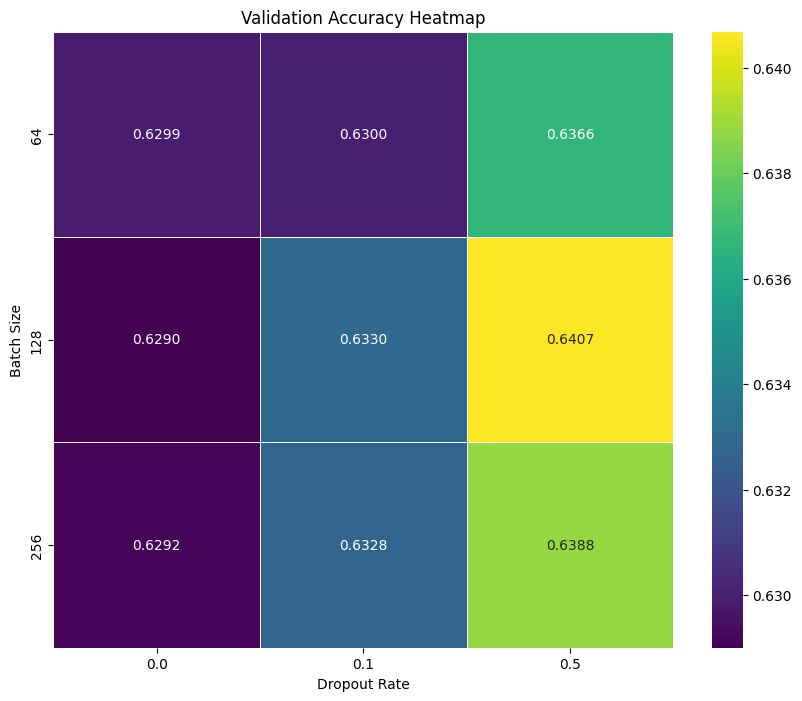

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(10, 8))

# Create the heatmap with annotations
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap='viridis', linewidths=0.5)

# Add labels and title
plt.title('Validation Accuracy Heatmap')
plt.xlabel('Dropout Rate')
plt.ylabel('Batch Size')

plt.savefig('validation_accuracy_heatmap.png')
# Show the plot
plt.show()

In [ ]:
from google.colab import files
files.download('validation_accuracy_heatmap.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

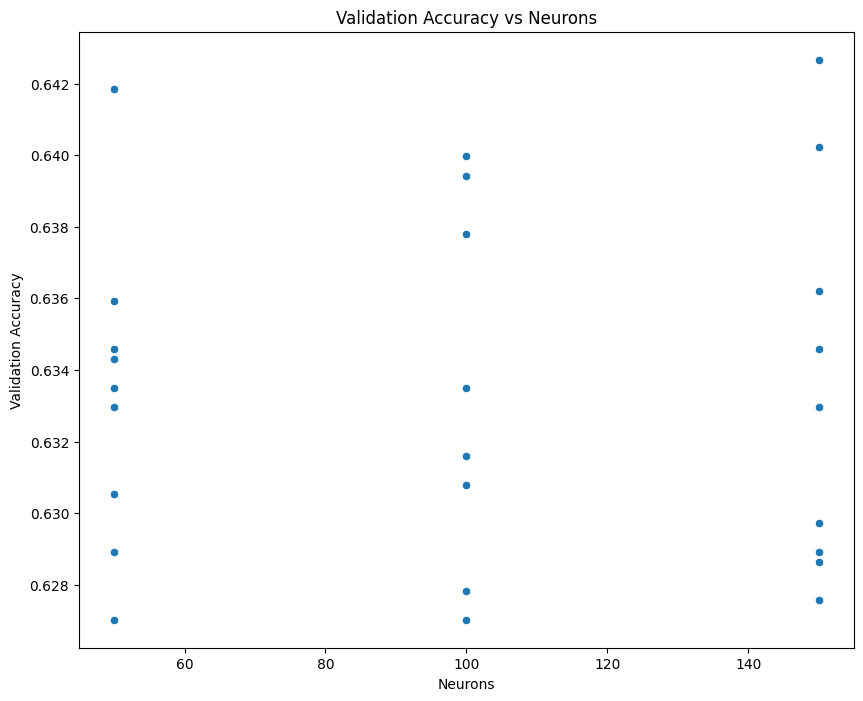

In [ ]:
# Load your CSV file into a DataFrame (replace 'model_results.csv' with your file name)
df = pd.read_csv('model_results.csv')

# Display the first few rows of the data to check
df.head()

# Set the size of the figure
plt.figure(figsize=(10, 8))

# Create a scatter plot of Validation Accuracy vs Neurons
sns.scatterplot(data=df, x='Neurons', y='Validation Accuracy')

# Add labels and title
plt.title('Validation Accuracy vs Neurons')
plt.xlabel('Neurons')
plt.ylabel('Validation Accuracy')

# Save the scatter plot as an image (e.g., PNG)
plt.savefig('validation_accuracy_vs_neurons_scatter.png')

# Show the plot
plt.show()


In [ ]:
from google.colab import files
files.download('validation_accuracy_vs_neurons_scatter.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

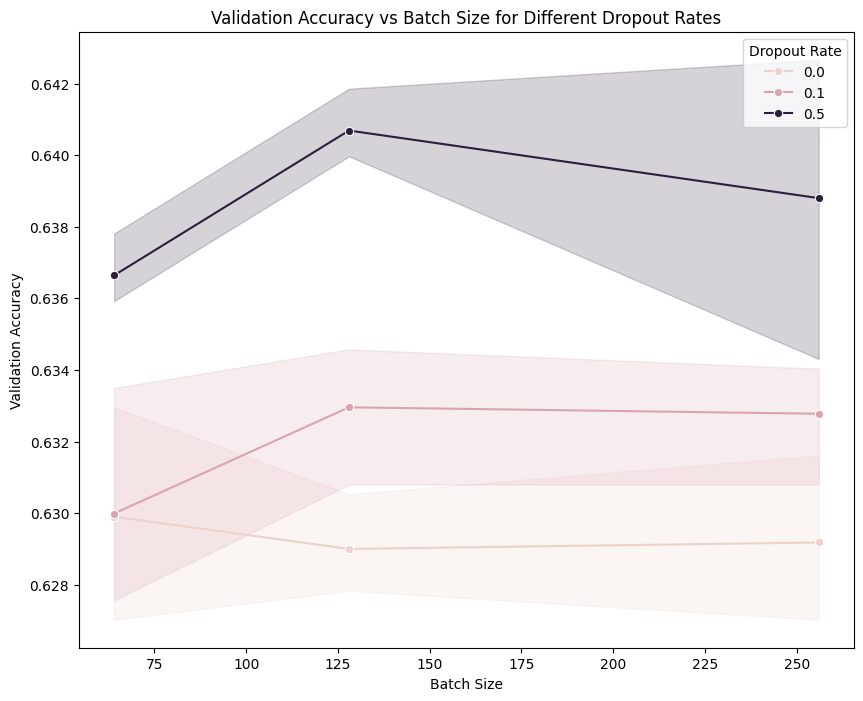

In [ ]:
  # Set the size of the figure
plt.figure(figsize=(10, 8))

# Create the line plot with different lines for different Dropout Rates
sns.lineplot(data=df, x='Batch Size', y='Validation Accuracy', hue='Dropout Rate', marker="o")

# Add labels and title
plt.title('Validation Accuracy vs Batch Size for Different Dropout Rates')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')

# Save the plot as a PNG file
plt.savefig('validation_accuracy_vs_batch_size_line_chart.png')

# Show the plot
plt.show()

In [ ]:
files.download('validation_accuracy_vs_batch_size_line_chart.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>